# Block[1-3]¶
To begin with the training process, we will import the dataset that was constructed during the feature selection phase and eliminate any extraneous columns from it in order to make it ready for training.

In [1]:
# Importing neccessary libraries for training and set logs to only show error messages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

In [2]:
#Read and trim the train dataset prepared in previous step
source = pd.read_csv('train.csv')
dataset = source.copy()
#Remove Date From dataset
dataset.drop(['Date' ], axis=1 ,inplace=True)
#Set target_short as the main label cause we are going to train long and drop other unnecessary columns
dataframe = dataset.copy()
dataframe['target'] = dataset['target_short']
#Custom drop list to be removed from dataframe. You can add or remove columns here based on your need
drop_list = [
    'close',
    'open',
    'high',
    'low',
    'sma9',
    'sma20',
    'sma200',
    'target_long',
    'target_short'
]
dataframe = dataframe.drop(drop_list, axis=1)

In [3]:
dataframe

,volume,sma200_4h,diff_sma9,diff_sma20,diff_sma200,diff_sma200_4h,diff_sma9_sma20,target
0,686.367415,NaN,-0.000961,-0.008023,-0.023196,NaN,-0.007068,0
1,613.539120,NaN,-0.002437,-0.010103,-0.025682,NaN,-0.007685,0
2,895.302181,NaN,-0.000964,-0.009124,-0.025261,NaN,-0.008168,0
3,796.714817,NaN,0.001341,-0.007466,-0.024130,NaN,-0.008795,0
4,1317.452909,NaN,0.001069,-0.006785,-0.023923,NaN,-0.007846,0
...,...,...,...,...,...,...,...,...
17540,1936.480276,21599.92275,0.015546,0.010303,0.115669,0.348463,-0.005163,0
17541,2524.473117,21599.92275,0.008593,0.004353,0.108392,0.341040,-0.004203,0
17542,1438.506320,21599.92275,0.010999,0.008351,0.112401,0.347266,-0.002620,0
17543,1976.419295,21599.92275,0.002706,0.002385,0.104471,0.339062,-0.000320,0


# Block[4-7]
We need to preprocess data for training a machine learning model in TensorFlow using feature columns to make it easier to train a neural network and improve the accuracy of the resulting model.

In [4]:
# Use the train_test_split function from the scikit-learn library to split our dataframe into training, validation, and testing sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(sum(train.target), '#train target')
print("-----------------")
print(len(val), 'validation examples')
print(sum(val.target), '#validation target')
print("-----------------")
print(len(test), 'test examples')
print(sum(test.target), '#test target')

11228 train examples
2750 #train target
-----------------
2808 validation examples
718 #validation target
-----------------
3509 test examples
866 #test target


In [5]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [6]:
batch_size = 32 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [7]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of targets:', label_batch )

example_batch = next(iter(train_ds))[0]

# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

Every feature: ['volume', 'sma200_4h', 'diff_sma9', 'diff_sma20', 'diff_sma200', 'diff_sma200_4h', 'diff_sma9_sma20']
A batch of targets: tf.Tensor([0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0], shape=(32,), dtype=int64)


In [8]:
#Make bound json file for storing the bucketized features bounds for further usage
import json
data = {}
with open('short_bound.json', 'w') as outfile:
        json.dump(data, outfile)
        
#Define a function to take the columns from dataset and save their boundaries.      
def build_bound(col,no):
    buk , ret = pd.qcut(dataframe[col],no, retbins = True )
    bound = []
    for i in ret:
        bound.append(i)

    bound.pop(0)
    bound.pop(-1)
    print("Boundaries " + col + ":",bound)
    
    ###save json
    f = open("short_bound.json", "r")
    data = json.load(f)
    data[col] = bound
    with open('short_bound.json', 'w') as outfile:
        json.dump(data, outfile)
    return bound

In [9]:
#Define numerical and bucketized features

#diffsma9
diff_sma9 = feature_column.numeric_column('diff_sma9')

#diff_sma200
bucksize = 6
bound = build_bound("diff_sma200",bucksize)
diff_sma200 = feature_column.numeric_column('diff_sma200')
diff_sma200_buckets = feature_column.bucketized_column(diff_sma200, boundaries=bound)

#diff_sma200_4h
bucksize = 6
bound = build_bound("diff_sma200_4h",bucksize)
diff_sma200_4h = feature_column.numeric_column('diff_sma200_4h')
diff_sma200_4h_buckets = feature_column.bucketized_column(diff_sma200_4h, boundaries=bound)

#diff_sma9_sma20
bucksize = 4
bound = build_bound("diff_sma9_sma20",bucksize)
diff_sma9_sma20 = feature_column.numeric_column('diff_sma9_sma20')
diff_sma9_sma20_buckets = feature_column.bucketized_column(diff_sma9_sma20, boundaries=bound)

Boundaries diff_sma200: [-0.0296349481545231, -0.0074924473916852, 0.0079104661004511, 0.0279396131881294, 0.058815372708410994]
Boundaries diff_sma200_4h: [-0.06290632204386784, -0.003489010443146234, 0.0386775882624073, 0.1021401567463601, 0.16666295332529912]
Boundaries diff_sma9_sma20: [-0.0028353280723926, 0.0004875399186031, 0.0042155178886833]


In [10]:
#Define feature columns to pass to model for training

feature_columns = []

feature_columns.append(diff_sma9)
feature_columns.append(diff_sma200_buckets)
feature_columns.append(diff_sma200_4h_buckets)
feature_columns.append(diff_sma9_sma20_buckets)

for col in feature_columns:
    print("Col Info:", col)
    print("-----------------")

Col Info: NumericColumn(key='diff_sma9', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
-----------------
Col Info: BucketizedColumn(source_column=NumericColumn(key='diff_sma200', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-0.0296349481545231, -0.0074924473916852, 0.0079104661004511, 0.0279396131881294, 0.058815372708410994))
-----------------
Col Info: BucketizedColumn(source_column=NumericColumn(key='diff_sma200_4h', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-0.06290632204386784, -0.003489010443146234, 0.0386775882624073, 0.1021401567463601, 0.16666295332529912))
-----------------
Col Info: BucketizedColumn(source_column=NumericColumn(key='diff_sma9_sma20', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-0.0028353280723926, 0.0004875399186031, 0.0042155178886833))
-----------------


In [11]:
# Create Feature Layer
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
feature_layer

# Block [12-15]

In [12]:
#Create a Model file to define and store the model parameters, enabling convenient access whenever needed.
long_model_file = 'crossover_short_model.py'

In [13]:
%%writefile {long_model_file}

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

def short_model(feature_layer):
    
    model = tf.keras.Sequential([
      feature_layer,
      layers.Dense(128, activation='relu'),
      layers.Dense(32, activation="relu"),
      layers.Dropout(0.05),
      layers.Dense(1, activation="sigmoid")
    ])

    epochs = 60
    learning_rate=0.1
    decay_rate = learning_rate / epochs

    opt = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, decay=decay_rate)
    los = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

    model.compile(
                  optimizer=opt,
                  loss='BinaryCrossentropy',
                  metrics=[tf.keras.metrics.TruePositives()])
    
    return model

Overwriting crossover_short_model.py


In [14]:
#import model file and add feature layer to it
import crossover_short_model
model = crossover_short_model.short_model(feature_layer)
model

In [15]:
#Training the data using the long_model we have defined.
from keras.callbacks import EarlyStopping, ModelCheckpoint

tf.random.set_seed(0)

cp_callback = [
             EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath=os.path.join("model_files", "crossover_short"), monitor='val_loss', save_best_only=True)
             ]

history = model.fit(train_ds, epochs=60, callbacks=[cp_callback], validation_data=val_ds)

print(model.summary())

Epoch 1/60
351/351 [==============================] - 3s 8ms/step - loss: 0.3444 - true_positives: 1365.0000 - val_loss: 0.3069 - val_true_positives: 505.0000
Epoch 2/60
351/351 [==============================] - 3s 7ms/step - loss: 0.3002 - true_positives: 1767.0000 - val_loss: 0.3027 - val_true_positives: 521.0000
Epoch 3/60
351/351 [==============================] - 2s 6ms/step - loss: 0.2974 - true_positives: 1801.0000 - val_loss: 0.2999 - val_true_positives: 475.0000
Epoch 4/60
351/351 [==============================] - 2s 6ms/step - loss: 0.2965 - true_positives: 1802.0000 - val_loss: 0.2978 - val_true_positives: 504.0000
Epoch 5/60
351/351 [==============================] - 1s 3ms/step - loss: 0.2942 - true_positives: 1806.0000 - val_loss: 0.2982 - val_true_positives: 504.0000
Epoch 6/60
351/351 [==============================] - 2s 6ms/step - loss: 0.2933 - true_positives: 1821.0000 - val_loss: 0.2978 - val_true_positives: 503.0000
Epoch 7/60
351/351 [==========================

# Block [16-18] 
Now that the training is done we examine the model's accuracy and how it evolves over the training process.

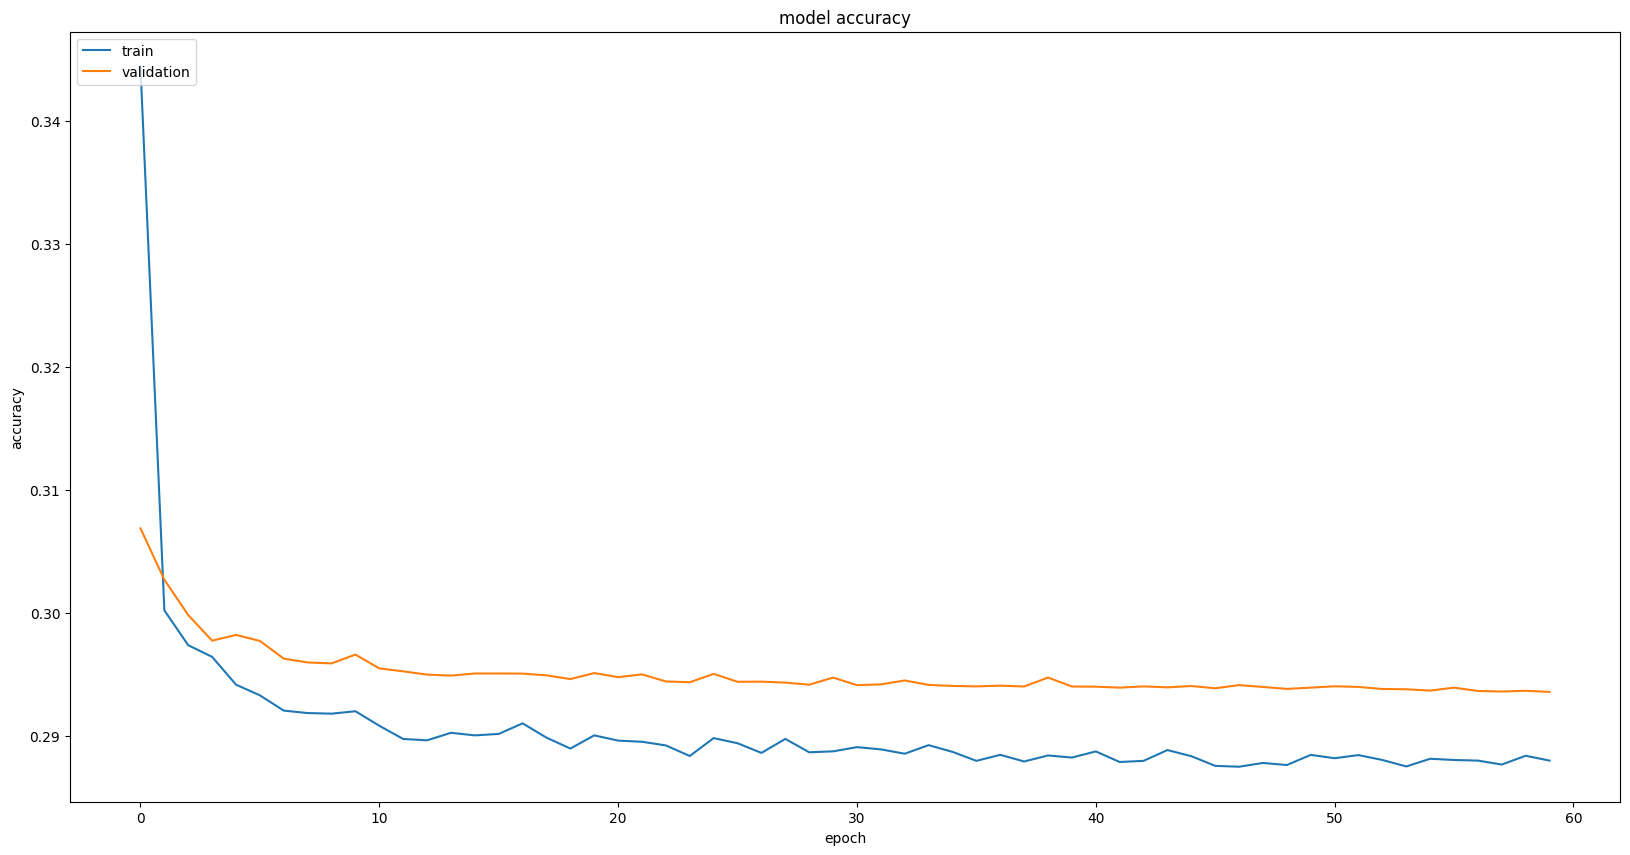

In [16]:
#Comparing the trends of the training and validation losses
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
#Evaluate the model accuracy on the test dataset
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)
accuracy_percent = accuracy/sum(test.target)*100
print("Accuracy %", accuracy_percent)

110/110 [==============================] - 0s 2ms/step - loss: 0.2931 - true_positives: 571.0000
Accuracy 571.0
Accuracy % 65.93533487297921


In [18]:
#Save the model for future use
print("----------save---------")
model.save_weights(os.path.join("model_files", "crossover_short"))

----------save---------
